This work was strongly inspired by this [notebook](https://mapie.readthedocs.io/en/latest/_downloads/7bde80a8852c5b5444d47ddddb7bb76c/plot_cqr_tutorial.ipynb).

# Regression problem
The [California Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html), from `sklearn`, was chosen for reproducibility and simplicity in the feature engineering step (in particular, there's no `nan` & just numerical variables). 

This dataset is composed of 20,640 samples of 8 different features:
- The median income in block group
- The median house age in block group
- The average number of rooms per household
- The average number of bedrooms per household
- The block group population
- The average number of household members
- The location (latitude & longitude) of the block group
While the label variable is:
- The median house price for a given block group

The complexity of this tabular dataset will require us to leverage gradient boosting techniques (instead of polynomial fits as in the [toy problem](https://github.com/gcastro-98/conformal-prediction/blob/main/toy_problem.ipynb)). In particular, we will use the Python _Light Gradient Boosting Machine_ [`LGBMRegressor`]():
- With `objective='quantile'`: for the conformalized Quantile Regression (`CQR`)
- With default `objective='regression'`: for the rest of implemented strategies (SCP, CV+, J+aB)
Besides, due to the considerable number of hyperparameters, a randomized search will be implemented to properly fine-tune each of them to the dataset.

**Note**: other gradient boosting methods, such as _eXtreme Gradient Boosting_ (XGB), could be used. However, `LGBM` was chosen as it already provides a user-friendly integration for quantile regression. The reader can refer to this [blog entry](https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b) for more details on how adapting the [`XGBRegressor`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) class to enable quantile regression.



We will compare 4 strategies in order to quantify the uncertainty: split (`SCP`), Cross- Jackknife+ after Bootstrap (`J+aB`), CQR (`CQR`).

In [1]:
import os
import pickle
import json  # to serialize the best hyperparameters found
import warnings  # to suppress them
from mapie.subsample import Subsample  # for the CV folds in the UQ process
from lightgbm import LGBMRegressor # the underlying model
from cp import data, visualize, validate, exchangeable, cv, logger as _logger
import matplotlib.pyplot as plt
import numpy as np

SEED: int = 123
np.random.seed(SEED)
MISCOVERAGE: float = 0.2 # MISCOVERAGE = alpha # CONFIDENCE = 1-alpha 
logger = _logger.Logger()
warnings.filterwarnings("ignore")  # to suppress them
os.makedirs('output/regression', exist_ok=True)

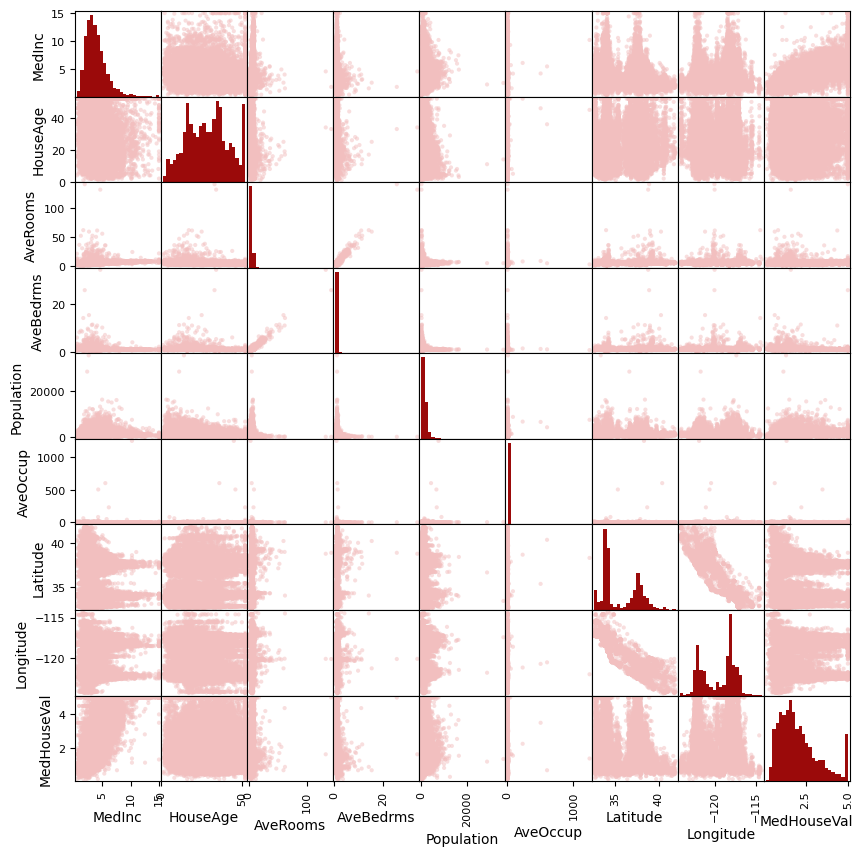

In [2]:
regression_problem = data.RegressionProblem()
X, y = regression_problem.data
X_train, X_test, y_train, y_test = data.split(X, y, seed=SEED)
regression_problem.visualize_data();

In [3]:
strategies_names = {
    'SCP': 'Split Conformal Prediction',
    'CV+': 'Cross Validation +',
    'J+aB': 'Jackknife+ after Bootstrapping',
    'CQR': 'Conformalized Quantile Regression'
}
strategies_params = {
    'SCP': {'method': 'base', 'cv': "split", "random_state": SEED},
    'CV+': {'method': "plus", 'cv': 10, "random_state": SEED},
    'J+aB': {'method': "plus", 'cv': Subsample(n_resamplings=50), "random_state": SEED},
    'CQR': {'method': "quantile", 'cv': "split", 'alpha': MISCOVERAGE}
}

## Using `LGBM` as model

We first define perform a random search to find out which are the best hyperparameters:
- **Note:** it may take a while.

In [4]:
hyperparameters_serialization_file: str = "output/regression/lgbm-hyperparameters.json"

if os.path.isfile(hyperparameters_serialization_file):
    logger.info("Retrieving best hyperparameters from local file")
    with open(hyperparameters_serialization_file, "r") as json_file:
        best_model_params: dict = json.load(json_file)
else:
    best_model_params = cv.fine_tune_lgbm(X_train, y_train)
    with open(hyperparameters_serialization_file, "w") as json_file:
        json.dump(best_model_params, json_file, indent=4)

logger.info(f"The best hyperparameters found were: {best_model_params}")
best_model_params.update({'random_state': SEED, 'verbose': 0})

05/29/2024 05:57:47 PM     INFO >> Computing best hyperparameters from randomized search
05/29/2024 05:57:47 PM    DEBUG >>     This may take a while (around 30')
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

### Definition of strategies

In [5]:
params = {
    'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 
    'miscoverage': MISCOVERAGE, 'seed': SEED
}

base_estimators = { 
    'SCP': LGBMRegressor(**best_model_params),
    'CV+': LGBMRegressor(**best_model_params),
    'J+aB': LGBMRegressor(**best_model_params),
    'CQR': LGBMRegressor(objective='quantile', alpha=0.5, **best_model_params),
} 

y_pred, int_pred, mapie_estimator = exchangeable.train_strategies(
    params, base_estimators, strategies_params, strategies_names)

05/29/2024 06:35:25 PM     INFO >> Training Split Conformal Prediction
05/29/2024 06:35:25 PM     INFO >> Training Cross Validation +
05/29/2024 06:35:29 PM     INFO >> Training Jackknife+ after Bootstrapping
05/29/2024 06:35:36 PM     INFO >> Training Conformalized Quantile Regression


In [6]:
# we could also predict the in-training samples
y_pred_train, int_pred_train = {}, {}

for _strat, _name in strategies_names.items():
    logger.info(f"Inferring in-training results for {_name}")
    if _strat != 'CQR':
        y_pred_train[_strat], int_pred_train[_strat] = mapie_estimator[_strat].predict(X_train, alpha=MISCOVERAGE)
    else:
        y_pred_train[_strat], int_pred_train[_strat] = mapie_estimator[_strat].predict(X_train)

05/29/2024 06:35:36 PM     INFO >> Inferring in-training results for Split Conformal Prediction
05/29/2024 06:35:36 PM     INFO >> Inferring in-training results for Cross Validation +
05/29/2024 06:35:44 PM     INFO >> Inferring in-training results for Jackknife+ after Bootstrapping
05/29/2024 06:35:51 PM     INFO >> Inferring in-training results for Conformalized Quantile Regression


Let's plot the results for the test set.

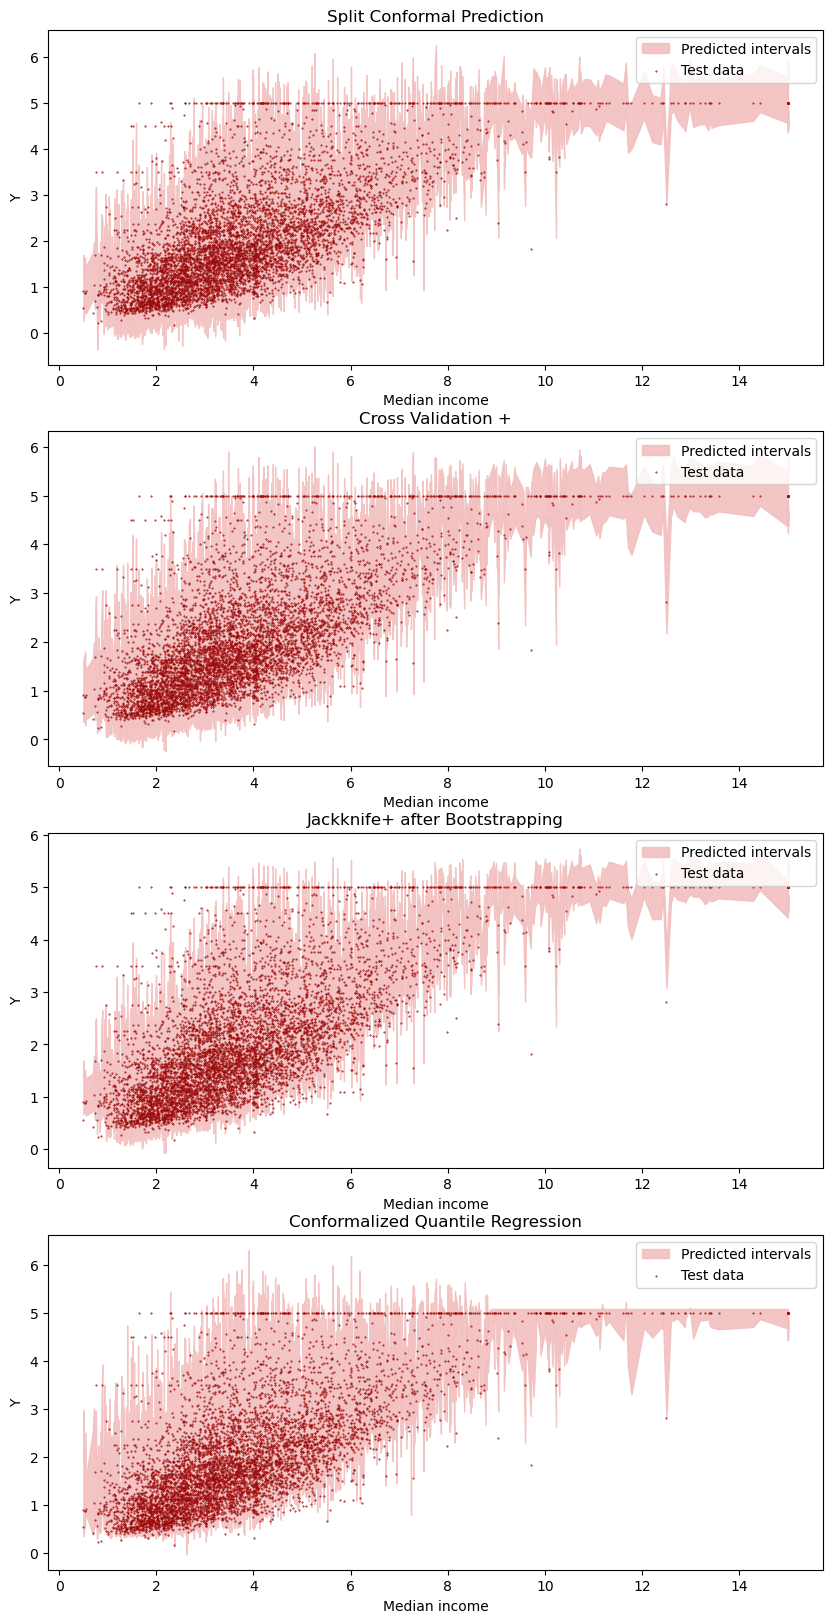

In [7]:
n_figs: int = len(base_estimators)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.data(
        {'X': X_test[:, 0].ravel(), 'y': y_test},
        bounds={
            'X': X_test[:, 0].ravel(), 
            'y_low': _y_pred_low, 
           'y_up': _y_pred_up},
        xlabel='Median income',
        title=strategies_names[_strat], 
        points_label='Test data',
        ax=axs[_i]
        )
plt.savefig('output/regression/prediction-intervals-regression-problem.png', dpi=200)
plt.show()
plt.close()

Let us assess some metrics and plot different validation figures:

- **Average goodness**

05/29/2024 06:35:55 PM     INFO >> Validating SCP coverage
05/29/2024 06:35:55 PM     INFO >> Validating CV+ coverage
05/29/2024 06:35:55 PM     INFO >> Validating J+aB coverage


05/29/2024 06:35:55 PM     INFO >> Validating CQR coverage
05/29/2024 06:35:55 PM     INFO >> Validating SCP width
05/29/2024 06:35:55 PM     INFO >> Validating CV+ width
05/29/2024 06:35:55 PM     INFO >> Validating J+aB width
05/29/2024 06:35:55 PM     INFO >> Validating CQR width
05/29/2024 06:35:55 PM     INFO >> Validating SCP RMSE
05/29/2024 06:35:55 PM     INFO >> Validating CV+ RMSE
05/29/2024 06:35:55 PM     INFO >> Validating J+aB RMSE
05/29/2024 06:35:55 PM     INFO >> Validating CQR RMSE
05/29/2024 06:35:55 PM     INFO >> Validating SCP CWC
05/29/2024 06:35:55 PM     INFO >> Validating CV+ CWC
05/29/2024 06:35:55 PM     INFO >> Validating J+aB CWC
05/29/2024 06:35:55 PM     INFO >> Validating CQR CWC


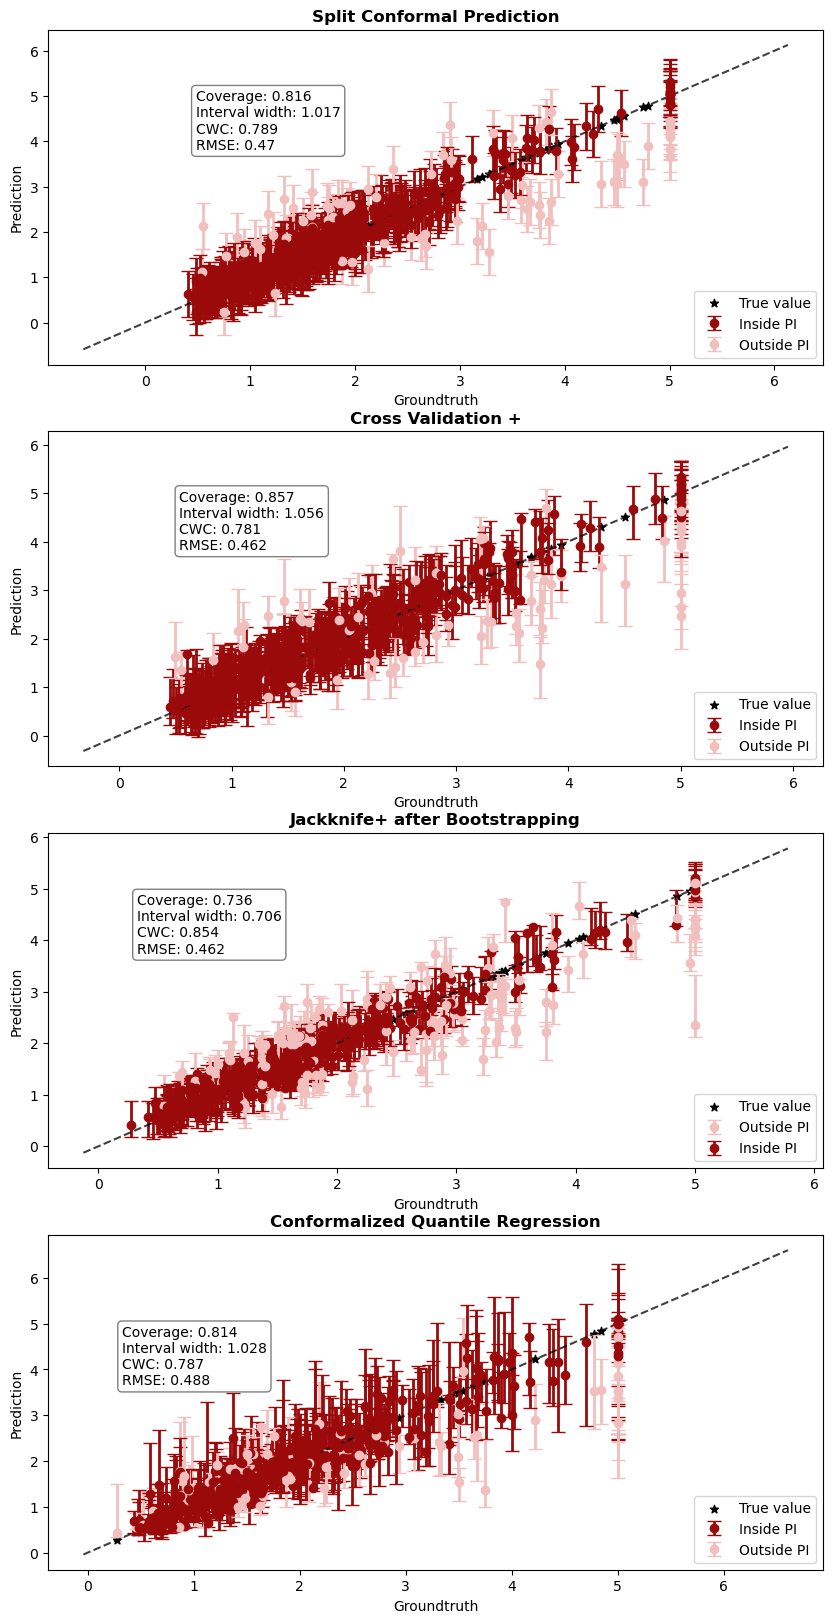

In [8]:
n_figs = len(base_estimators)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

coverages: dict = validate.coverage(int_pred, y_test)
widths: dict = validate.width(int_pred)
rmse: dict = validate.rmse(y_pred, y_test)
cwc: dict = validate.cwc(int_pred, y_test, MISCOVERAGE)

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.goodness(
        y_test, y_pred[_strat],
        _y_pred_low, 
        _y_pred_up,
        coverages[_strat],
        widths[_strat],
        rmse[_strat],
        cwc[_strat],
        ax=axs[_i],
        subsample=0.075,
        title=strategies_names[_strat], 
    )
plt.savefig('output/regression/average-goodness-regression-problem.png', dpi=200)
plt.show()
plt.close()

For visualization purposes, note that just a 7.5% of the test data was shown. 

- Marginal vs. conditional coverage: **width occurrence**

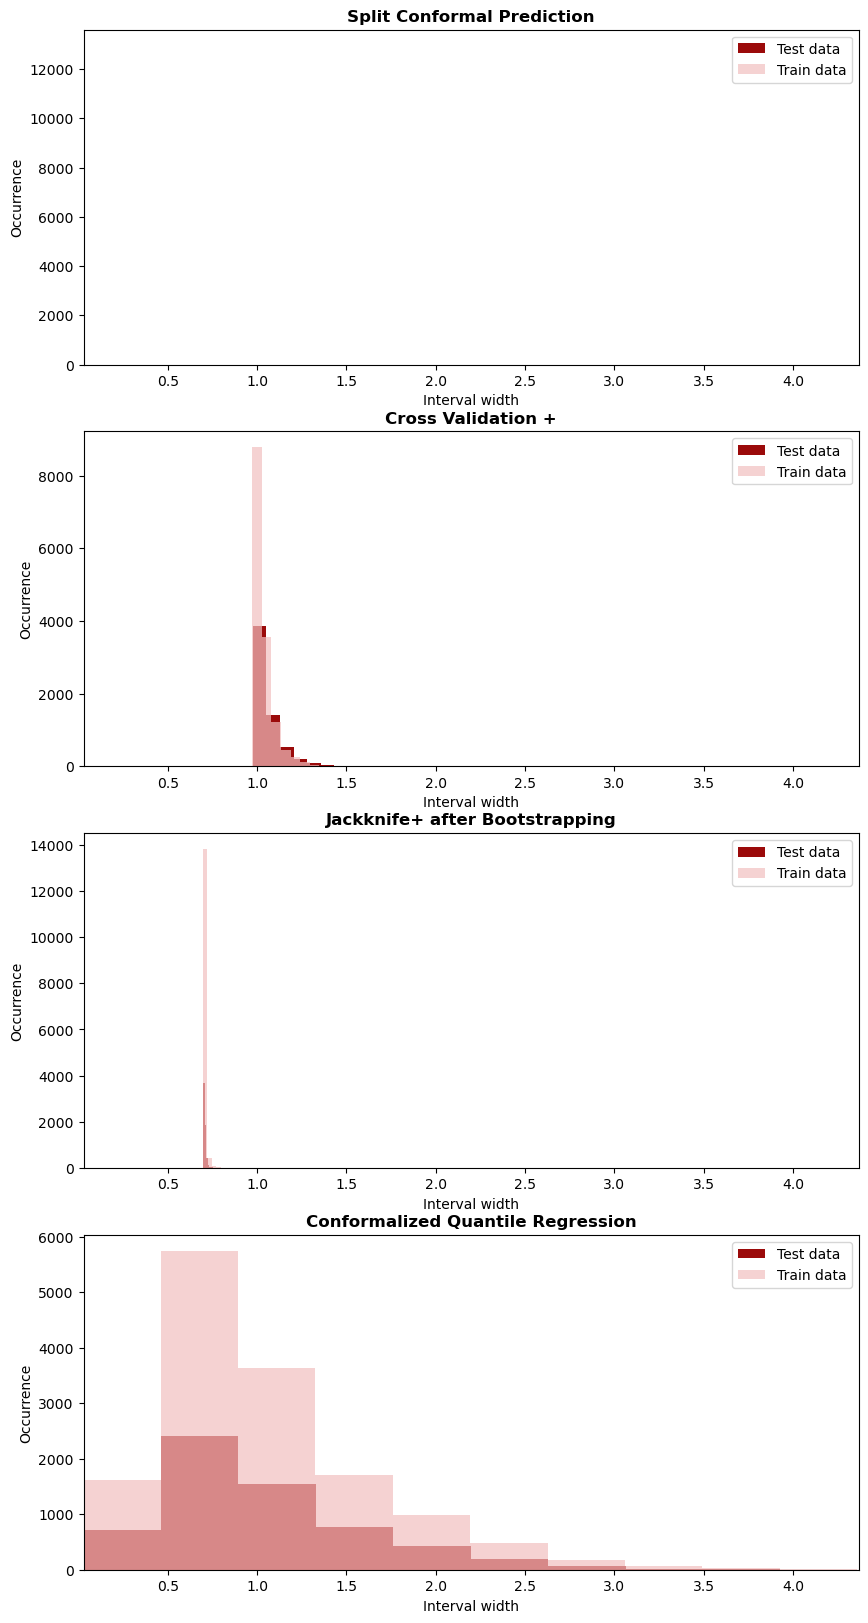

In [9]:
n_figs = len(base_estimators)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

_x_max = (1+1e-3) * np.max([np.abs(int_pred[_strat][:, 0, 0] - int_pred[_strat][:, 1, 0]) for _strat in int_pred.keys()]) 
_x_min = np.min([np.abs(int_pred[_strat][:, 0, 0] - int_pred[_strat][:, 1, 0]) for _strat in int_pred.keys()])

for _i, _strat in enumerate(base_estimators.keys()):
    # Visualize
    axs[_i] = visualize.width_size_occurrence(
        int_pred[_strat],
        train_intervals=int_pred_train[_strat],
        num_bins=10,
        ax=axs[_i],
        x_lim=[_x_min, _x_max],
        title=strategies_names[_strat], 
    )
plt.savefig('output/regression/width-occurrence-regression-problem.png', dpi=200)
plt.show()
plt.close()

- Marginal vs. conditional coverage: **coverage vs. width**
    - Since `SCP` provides constant-width intervals, its plot is omitted.

05/29/2024 06:36:06 PM  WARNING >> This metric should be used only with non constant intervals (intervals of different sizes), with constant intervals the result may be misinterpreted.
05/29/2024 06:36:06 PM  WARNING >> Size-Stratified Coverage score set to 0 for SCP
05/29/2024 06:36:06 PM     INFO >> Validating CV+ Size-Stratified Coverage
05/29/2024 06:36:06 PM     INFO >> Validating J+aB Size-Stratified Coverage
05/29/2024 06:36:06 PM     INFO >> Validating CQR Size-Stratified Coverage
05/29/2024 06:36:06 PM     INFO >> Validating SCP HSIC coefficient
05/29/2024 06:36:11 PM     INFO >> Validating CV+ HSIC coefficient
05/29/2024 06:36:15 PM     INFO >> Validating J+aB HSIC coefficient
05/29/2024 06:36:20 PM     INFO >> Validating CQR HSIC coefficient


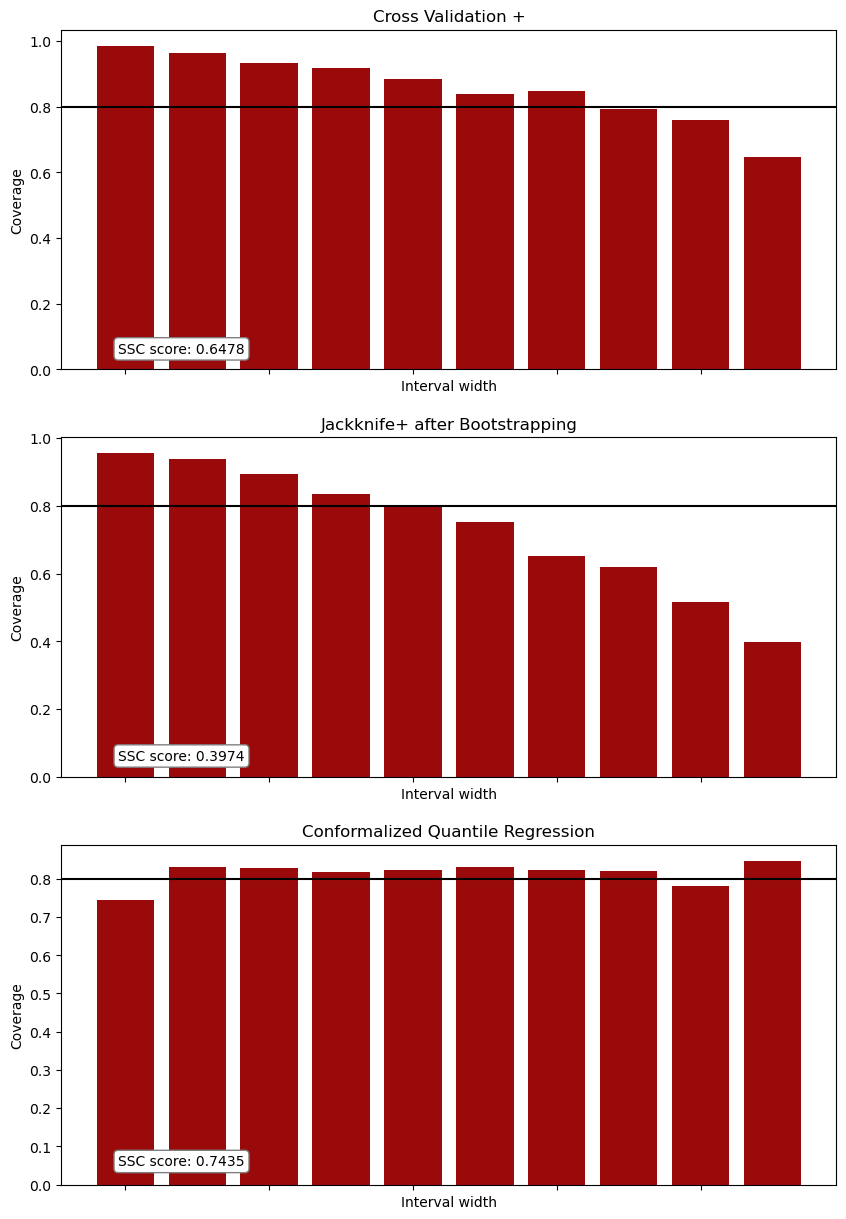

In [10]:
_strategies = [_s for _s in strategies_names.keys() if _s != 'SCP']
NUM_BINS: int = 10
n_figs = len(_strategies)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

cond_coverages: dict = validate.cond_coverage(int_pred, y_test, num_bins=NUM_BINS)
hsic_coefficients: dict = validate.hsic_coefficient(int_pred, y_test) 

for _i, _strat in enumerate(_strategies):
    axs[_i] = visualize.coverage_by_width(
        y_test, int_pred[_strat], MISCOVERAGE,
        cond_coverages[_strat],
        # hsic_coefficients[_strat],
        num_bins=NUM_BINS,
        ax=axs[_i],
        title=strategies_names[_strat], 
    )
plt.savefig('output/regression/coverage-vs-width-regression-problem.png', dpi=200)
plt.show()
plt.close()

For a more detailed interpretation of SSC score and the HSIC coefficient, one can refer to this [page](https://mapie.readthedocs.io/en/stable/examples_regression/2-advanced-analysis/plot_conditional_coverage.html). Below a list with the all metrics shown so far is represented.

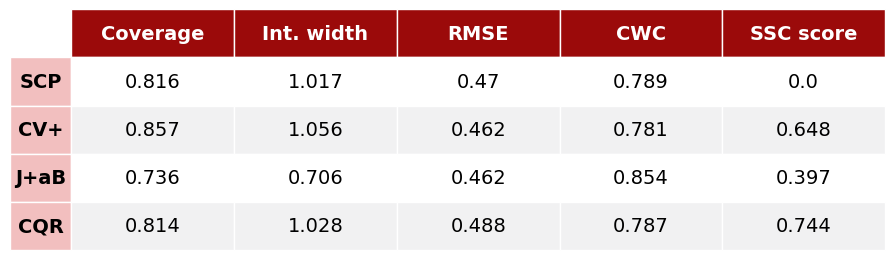

In [11]:
metrics_df = visualize.dicts_to_dataframe(
    {'Coverage': coverages, 'Int. width': widths, 
     'RMSE': rmse, 'CWC': cwc, 
     'SSC score': cond_coverages, 
     # 'HSIC': hsic_coefficients,
     })

visualize.dataframe_to_png(metrics_df, 'output/regression/metrics-table-regression-problem.png')

- **Coverage sougth for different values of $\alpha$**: and, finally, a visualization which displays the performance of each strategy when $\alpha$ is changed

In [12]:
CV_RESULTS: str = 'output/regression/coverage-cv-results-regression.pickle'
MISCOVERAGES_LIST: np.ndarray = np.round(np.linspace(0.01, 0.20, 5), 2)
N_FOLDS: int = 10

if os.path.isfile(CV_RESULTS):
    logger.info("Opening serialized CV results")
    with open(CV_RESULTS, 'rb') as f:
        coverages_dict = pickle.load(f)
else:
    coverages_dict = {}
    logger.info("Training the different strategies and for different alpha values")
    logger.debug(4 * " " + "This may take a while (AROUND 10' MINUTES)")

    for _strat, base_estimator in base_estimators.items():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            coverages_dict[_strat] = cv.coverage_in_function_of_alpha(
                X, y, MISCOVERAGES_LIST, base_estimator, strategies_params[_strat], 
                _strat, SEED, silent=True, K=N_FOLDS)
    
    logger.info("Serializing obtained CV results")
    with open(CV_RESULTS, 'wb') as f:
        pickle.dump(coverages_dict, f)

05/29/2024 06:36:26 PM     INFO >> Training the different strategies and for different alpha values
05/29/2024 06:36:26 PM    DEBUG >>     This may take a while (AROUND 15' MINUTES)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

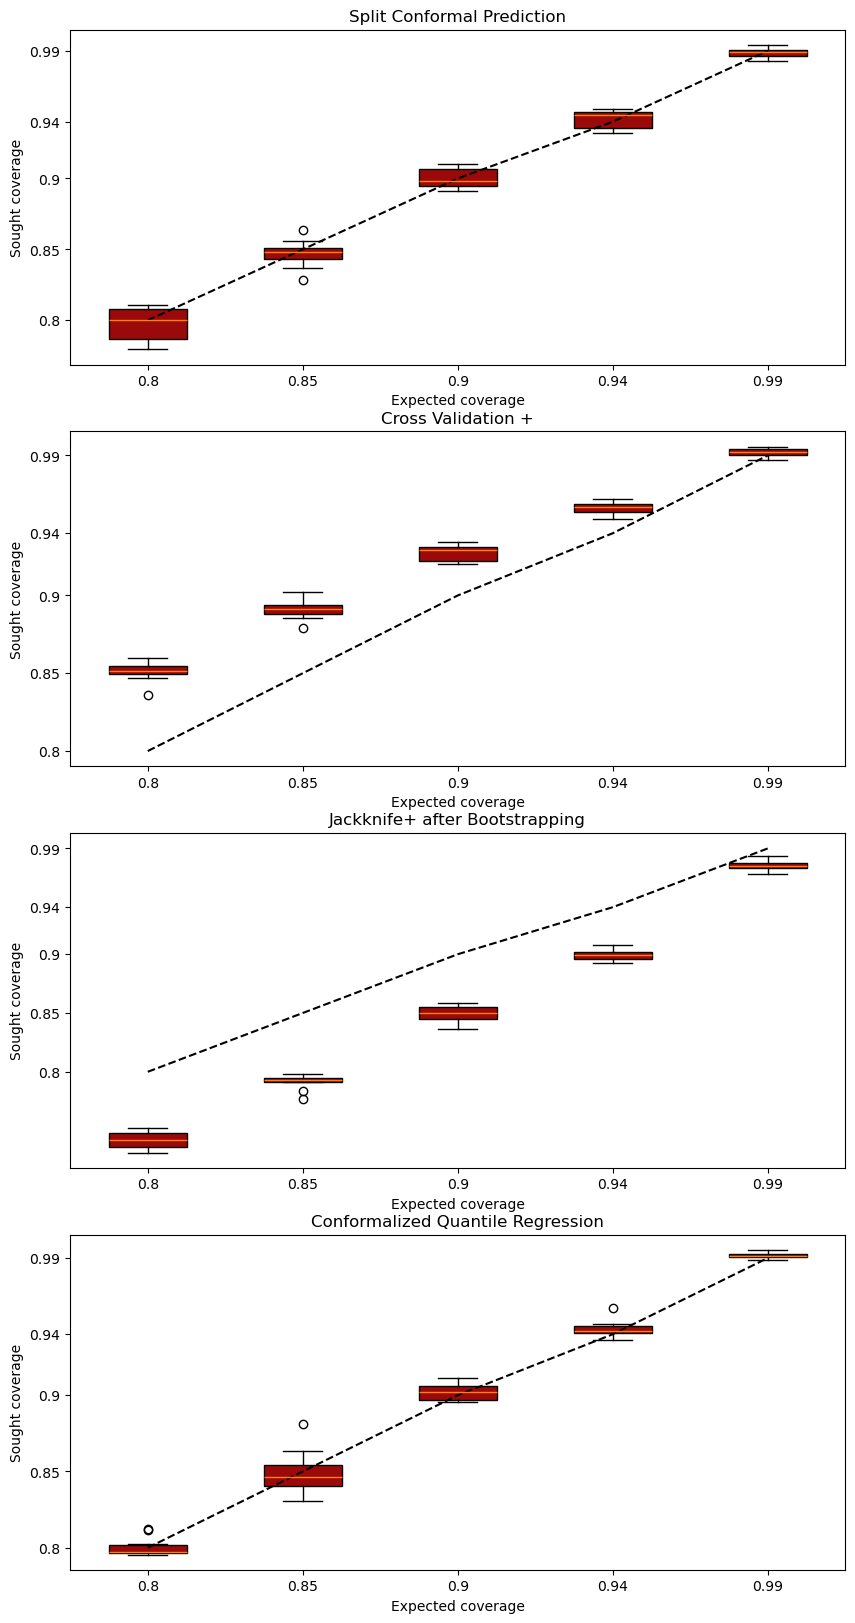

In [13]:
n_figs = len(base_estimators)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

for _i, _strat in enumerate(base_estimators):
    axs[_i] = visualize.coverage_by_alpha(
        coverages_dict[_strat], 
        MISCOVERAGES_LIST, 
        strategies_names[_strat],
        ax=axs[_i]
        )
plt.savefig('output/regression/coverage-vs-alpha-regression-problem.png', dpi=200)
plt.show()
plt.close()